In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import statsmodels.api as sm

In [ ]:
# считываем файл
df = pd.read_excel('/content/Тема 10.xlsx', sheet_name = 'Лист15')[1:]
df.head(6)

,T,IP2_DEA_M,Unnamed: 2,"Индекс производства в секторе ""Обеспечение электрической энергией. газом и паром; кондиционирования воздуха"" по ОКВЭД2 (IP2_DEA_M)"
1,2014 1,100,NaN,NaN
2,2,91.2,NaN,NaN
3,3,87,NaN,NaN
4,4,74.5,NaN,NaN
5,5,61.7,NaN,NaN
6,6,55.3,NaN,NaN


In [ ]:
# выделяем x и y
x = [i for i in range(len(df['T']))]
y = [i for i in df['IP2_DEA_M'].values]
print(x[:5], y[:5])

[0, 1, 2, 3, 4] [100, 91.2, 87, 74.5, 61.7]


In [ ]:
y = pd.DataFrame(y)

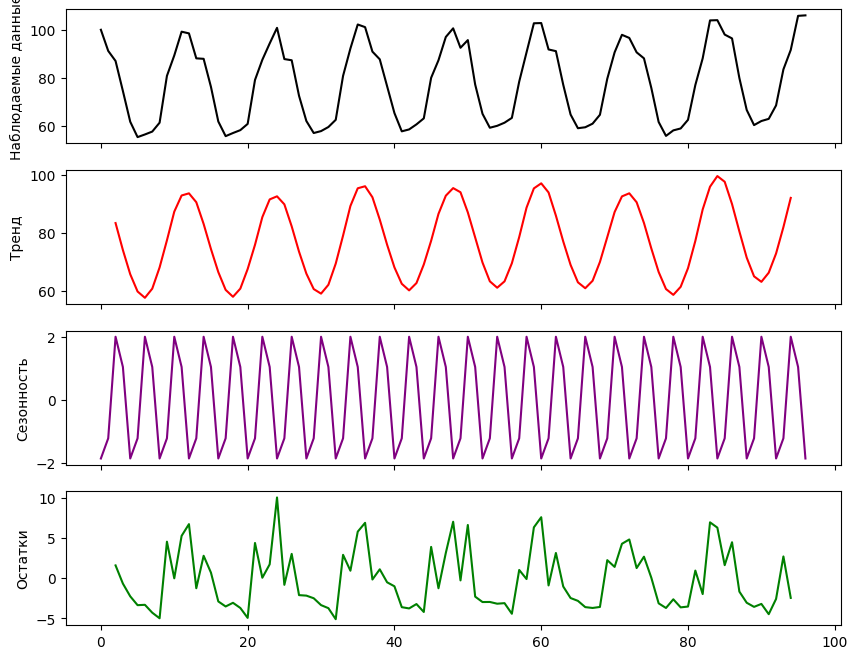

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y, model='additive', period=4)
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,8))
result.observed.plot(ax=axes[0], legend=False, color='black')
axes[0].set_ylabel('Наблюдаемые данные')
result.trend.plot(ax=axes[1], legend=False, color='red')
axes[1].set_ylabel('Тренд')
result.seasonal.plot(ax=axes[2], legend=False, color='purple')
axes[2].set_ylabel('Сезонность')
result.resid.plot(ax=axes[3], legend=False, color='green')
axes[3].set_ylabel('Остатки')
plt.show()

По графикам видно периодические колебания данных, следовательно, есть сезонность и отсутствие тренда.

# Предварительный анализ временных рядов

**Выявление аномальных значений**

**Использование распределения Стьюдента (т.к. есть сезонность)**

In [ ]:
y_ = np.mean(y) # среднее
Sy = np.std(y) # среднеквадратическое отклонение
n = len(y)
yy = np.argmax(y-y_) # наблюдение, предположительно являющееся аномальным

t_ = (yy - y_) / Sy # статистика

t_crit = t.ppf(1 - (0.05 / 2), n-2) # критическое значение распределения Стьюдента

t_005 = (t_crit * np.sqrt(n-1))/(np.sqrt(n - 2 + t_crit**2))

In [ ]:
t_ <= t_005

True

Следовательно, наблюдения нельзя считать аномальными.

**Проверка наличия тренда**

**Метод проверки разностей стредних уровней**

In [ ]:
# считаем расчетное значение критерия Фишера
med = round(len(y)/2)
y1 = y[:med]
y2 = y[med:]

var1 = np.var(y1)
var2 = np.var(y2)

F = var2/var1
F

1.0888006019787806

In [ ]:
# считаем табличное значение критерия Фишера
from scipy.stats import f
alpha = 0.05

F_crit = f.ppf(1 - alpha, len(y1) - 1, len(y2) - 1)
F_crit

1.618422896995447

In [ ]:
F < F_crit # гипотеза о равенстве дисперсий принимается
# переходим к следующему этапу

True

In [ ]:
# считаем расчетное значение критерия Стьюдента
n1, n2 = len(y1), len(y2)

s = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
t = abs(np.mean(y1) - np.mean(y2))/(s*np.sqrt(1/n1 + 1/n2))
t

0.9002574394434417

In [ ]:
# считаем табличное значение критерия Стьюдента
from scipy.stats import t
alpha = 0.05

t_crit = t.ppf(1 - alpha/2, (n1+n2-2))
t_crit

1.9852510034099262

Гипотеза об отсутствии тенденции принимается, так как t < t_crit.

**Сглаживание временных рядов**

**Простая (среднеарифметическая) скользящая средняя**

In [ ]:
# функция для сглаживания, которая вычисляет скользящее среднее для одномерного массива
def moving_average(data, window):
    ma= []
    for i in range(window-1, len(data)):
        ma.append(sum(data[i-window+1:i+1])/window)
    return ma
window_size = 4 # размер окна сглаживания
rolling_mean = df.rolling(window=window_size).mean()

<ipython-input-53-3a90dea0ca57>:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['T'], dtype='object')
  rolling_mean = df.rolling(window=window_size).mean()


In [ ]:
y_new = moving_average(y, window_size)
y_new[:6]

[88.175, 78.6, 69.625, 61.975, 57.75, 57.64999999999999]

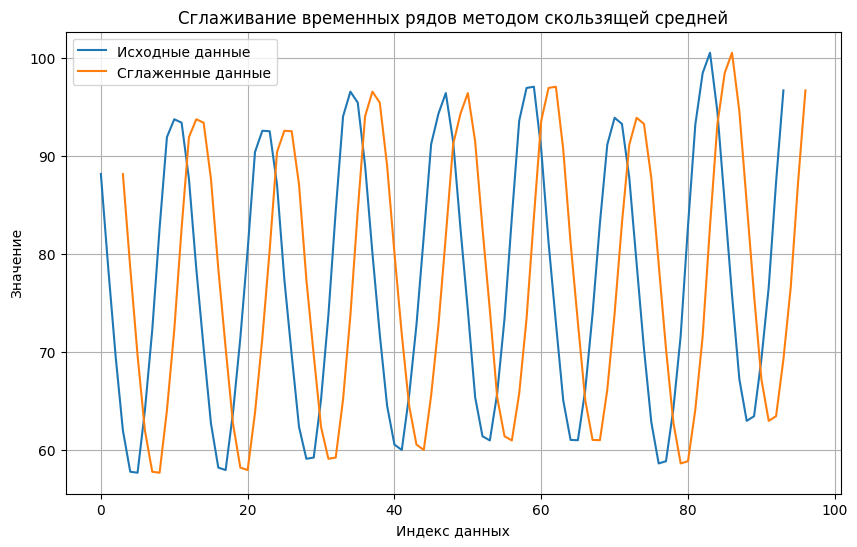

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_new, label='Исходные данные')
plt.plot(np.arange(window_size - 1, len(y)), moving_average(y, window_size), label=f'Сглаженные данные')
plt.xlabel('Индекс данных')
plt.ylabel('Значение')
plt.legend()
plt.title('Сглаживание временных рядов методом скользящей средней')
plt.grid(True)
plt.show()

# Задания

# **1**

In [ ]:
dyt = [(y_new[i+1]+y_new[i-1])/2 for i in range(1, len(y_new)-1)] # первый средний прирост
dyt2 = [(dyt[i+1]+dyt[i-1])/2 for i in range(1, len(dyt)-1)] # второй средний прирост
# производные величины
dyt_y = [dyt[i-1]/y_new[i] for i in range(1, len(y_new)-1)]
log_y = np.log(dyt)
log_dyt = np.log(dyt_y)
log_dyt2 = np.log([dyt[i-1]/y_new[i]**2 for i in range(1, len(y_new)-1)])

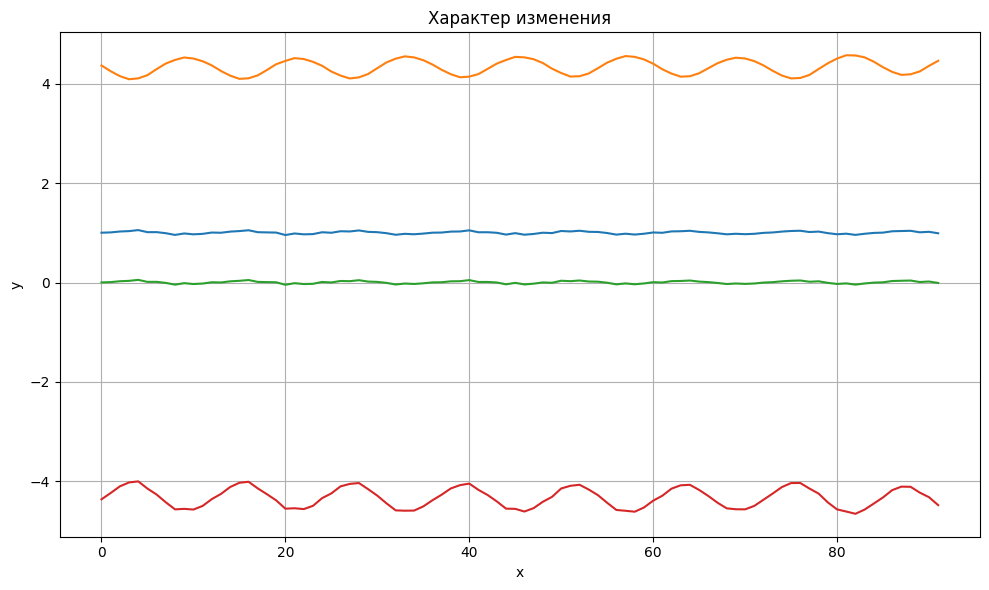

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
list = [dyt_y, log_y, log_dyt, log_dyt2]
for i in list:
    ax.plot(i)
ax.set_title('Характер изменения')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
plt.tight_layout()
plt.show()

Характер изменения примерно постоянный => кривая роста - экспонента.

Строим кривую роста:

In [ ]:
from scipy.optimize import minimize
x = np.array(x)

par = [0, 0]  # начальное приближение
def func(params):
    a, b = params
    pred_y = a * np.exp(b * x)
    return np.sum((y - pred_y) ** 2) # вычисление суммы квадратов разностей

result = minimize(func, par) # минимизация с помощью МНК
optimul = result.x

In [ ]:
a, b = optimul
y_opt = a * np.exp(b * x)

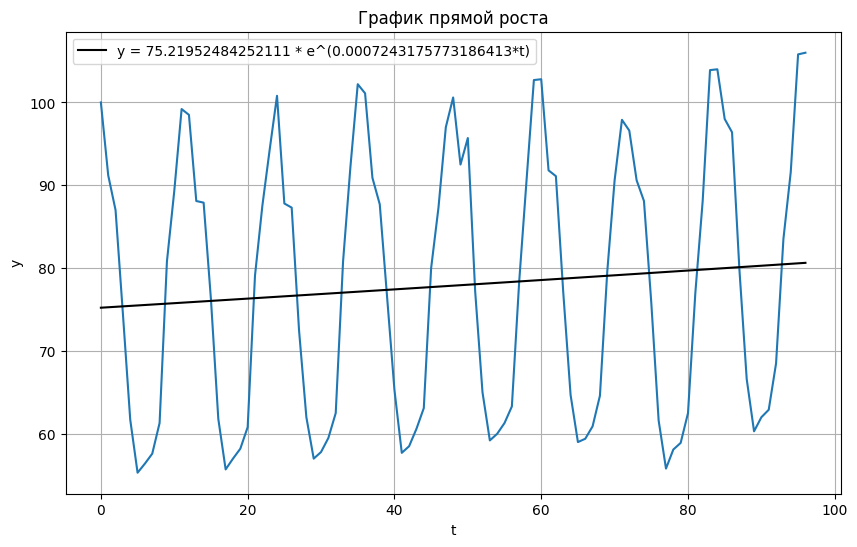

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.plot(x, y_opt, label=f'y = {a} * e^({b}*t)', color = 'black')
plt.xlabel('t')
plt.ylabel('y')
plt.title('График прямой роста')
plt.legend()
plt.grid(True)
plt.show()

# **2**

Точечный прогноз на 4 периода вперед:

In [ ]:
t_bud = np.arange(len(x), len(x) + 4, 1) # время на 4 шага вперед
y_toch = a * np.exp(b * t_bud)

print("Точечный прогноз на 4 периода вперед:", y_toch)

Точечный прогноз на 4 периода вперед: [80.92856981 80.98720903 81.04589074 81.10461497]


Интервальный прогноз на 4 периода вперед:

In [ ]:
from scipy.stats import t as t_test

ost = y - (a * np.exp(b * t))
Sy = np.sqrt(np.sum(ost ** 2) / (len(x) - 2))
alpha = 0.05
t_a = t_test.ppf(1 - alpha, len(x) - 2)

# Ширина доверительного интервала
U = t_a * Sy * np.sqrt(1 + 1/n + (101-50)**2/sum((xi - 50)**2 for xi in x))

print("Верхняя граница интервального прогноза:", y_toch + U)
print("Нижняя граница интервального прогноза:", y_toch - U)

Верхняя граница интервального прогноза: [107.97429991 108.03293913 108.09162084 108.15034507]
Нижняя граница интервального прогноза: [53.88283971 53.94147893 54.00016064 54.05888486]


# **3**

In [ ]:
time = pd.date_range(start='1/1/2014', periods=len(y), freq='M')
vr = pd.Series(y, index=time)

# подгонка адаптивной модели Хольта к исходным данным
model = sm.tsa.Holt(vr).fit()

# предсказание на 4 периода
pred = model.forecast(steps=4)

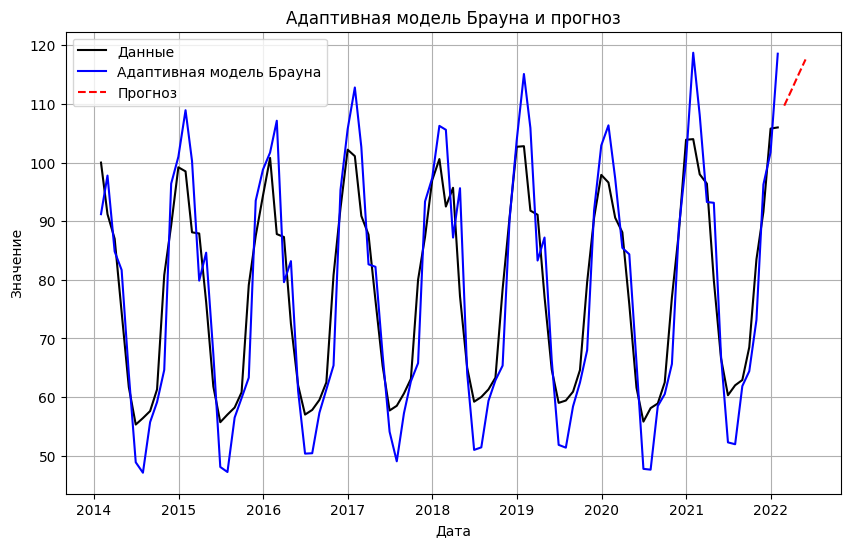

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Адаптивная модель Брауна и прогноз')
plt.plot(vr, color='black', label='Данные')
plt.plot(model.fittedvalues, color='blue', label='Адаптивная модель Брауна')
plt.plot(pred, color='red', linestyle='--', label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

# **4**

In [ ]:
time = pd.date_range(start='1/1/2014', periods=len(y), freq='M')
vr = pd.Series(y, index=time)
# построение модели Хольта-Уинтерса без тренда, но с сезонностью
# так как на графике видно, что сезонность присутствует
# (имеются периодические колебания вокруг постоянного уровня)
model = sm.tsa.ExponentialSmoothing(vr, trend=None, seasonal='add', seasonal_periods=12).fit()

pred = model.forecast(steps=10) # прогнозирование будущих значений

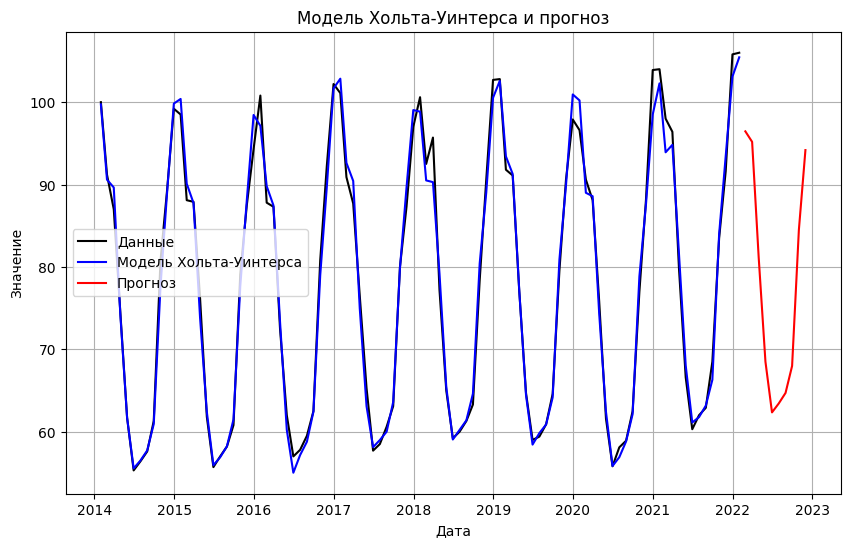

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Модель Хольта-Уинтерса и прогноз')
plt.plot(vr, color='black', label='Данные')
plt.plot(model.fittedvalues, color='blue', label='Модель Хольта-Уинтерса')
plt.plot(pred, color='red', label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

# **5**

In [ ]:
import statsmodels.api as sm

time = pd.date_range(start='1/1/2014', periods=len(y), freq='M')
vr = pd.Series(y, index=time)

# Выделение компонент методом Четверикова
# Разложение на сезонную, трендовую и остаточную составляющие
decomposition = sm.tsa.seasonal_decompose(vr, model='additive')

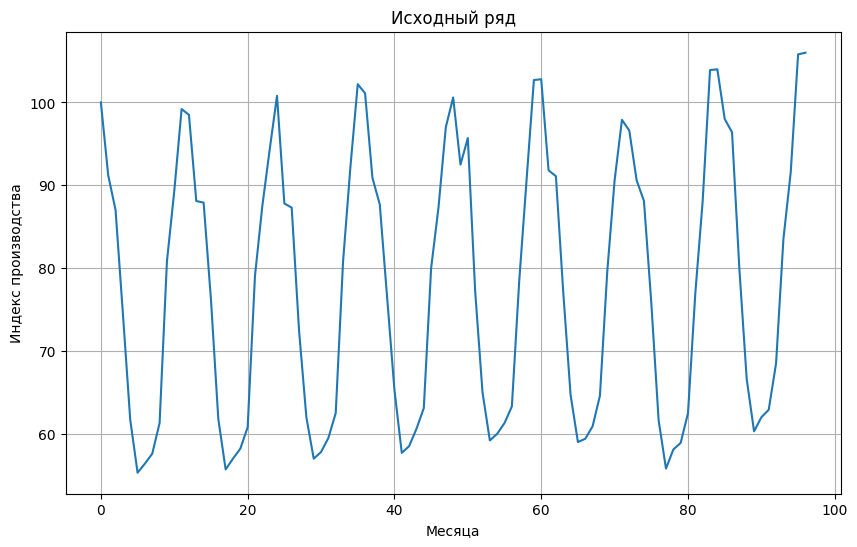

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Исходный ряд')
plt.xlabel('Месяца')
plt.ylabel('Индекс производства')
plt.grid(True)
plt.show()

Тренд по тесту отсутствует.

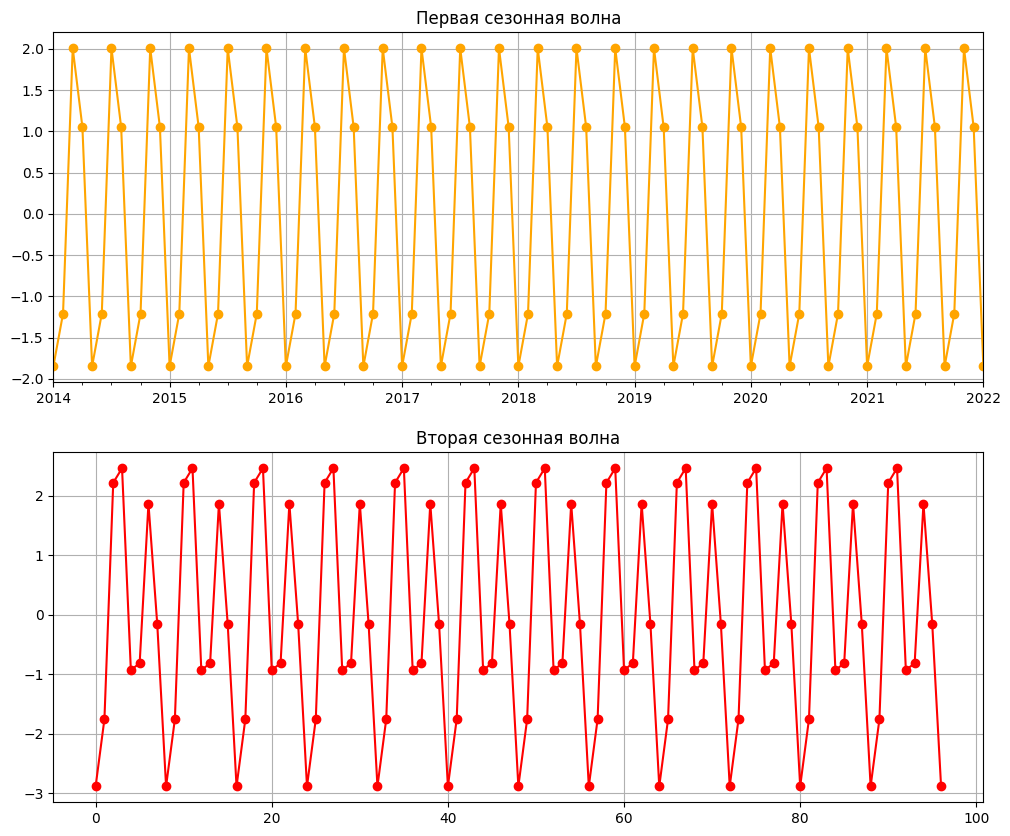

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(nrows=2, figsize=(12, 10))

# Построение первой сезонной волны
axes[0].set_title('Первая сезонная волна')
decomposition = sm.tsa.seasonal_decompose(vr, model='additive', period=4)
decomposition.seasonal.plot(ax=axes[0], color='orange', marker='o')
axes[0].grid();

# Построение второй сезонной волны
axes[1].set_title('Вторая сезонная волна')
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=4*2)
decomposition.seasonal.plot(ax=axes[1], color='red', marker='o')
axes[1].grid()
plt.show()

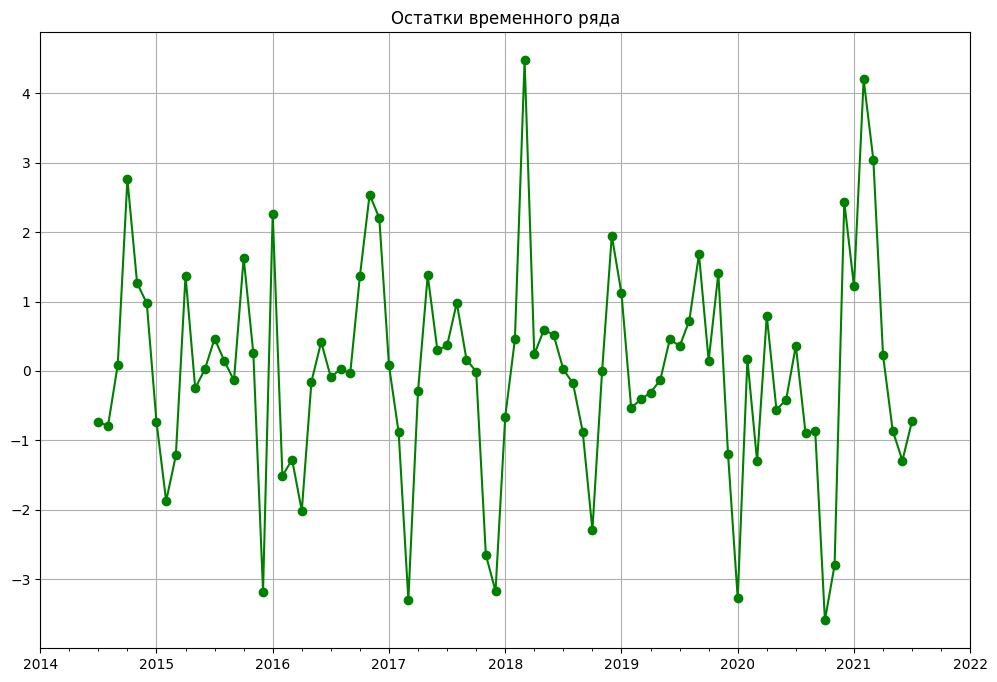

In [ ]:
# Остаточная компонента
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
plt.title('Остатки временного ряда')
decomposition.resid.plot(marker='o', color='green')
plt.grid()